<a href="https://colab.research.google.com/github/frank-morales2020/generative-ai-on-aws-book/blob/main/01_generate_text2image_sdxl_CAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a id='toc1_'></a>[1. Subscribe to the SDXL Model Package](#toc0_)

To subscribe to the SDXL Model Package:
1. Open the SDXL Model Package listing page: https://aws.amazon.com/marketplace/pp/prodview-pe7wqwehghdtm
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization accept the EULA, pricing, and support terms.

In [1]:
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
! pip install protobuf==3.20

import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3

  Cloning https://github.com/Stability-AI/stability-sdk.git (to revision sagemaker) to /tmp/pip-install-j_bnnqys/stability-sdk_6c39be3200ca468c85086ada39eb016d
  Running command git clone --filter=blob:none --quiet https://github.com/Stability-AI/stability-sdk.git /tmp/pip-install-j_bnnqys/stability-sdk_6c39be3200ca468c85086ada39eb016d
  Running command git checkout -b sagemaker --track origin/sagemaker
  Switched to a new branch 'sagemaker'
  Branch 'sagemaker' set up to track remote branch 'sagemaker' from 'origin'.
  Resolved https://github.com/Stability-AI/stability-sdk.git to commit 41773a9366d3bef3d32f59c7ff1d1939fbe5212e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.5 MB/s eta 0:00:00
     ━━━

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# <a id='toc2_'></a>[2: Create an endpoint and perform real-time inference](#toc0_)

In [2]:
# Choose your endpoint name
from sagemaker.utils import name_from_base
endpoint_name=name_from_base('sdxl-1-0-intro') # change this as desired
endpoint_name

'sdxl-1-0-intro-2023-12-15-07-19-29-244'

Once you have subscribed to Stability SDXL, get the Model Package ARN using the map below:


In [3]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad"
}


#added by Frank MOrales december 15th, 2023
!pip install colab-env --upgrade
import colab_env
import os
aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
region=os.getenv("AWS_DEFAULT_REGION")
output=os.getenv("AWS_DEFAULT_OUTPUT")


import sagemaker
import boto3

# Start setting up a SageMaker session and a Boto3 SageMaker client
#session = sagemaker.Session()

## added by frank morales
sagemaker_client = boto3.client('sagemaker', region_name=region)

if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")

package_arn = model_package_map[region]  # TODO
role_arn = get_execution_role()
sagemaker_session = sagemaker.session.Session( sagemaker_client= sagemaker_client )

  Preparing metadata (setup.py) ... done
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3805 sha256=1386c0d93e401d626891b40b509cbb360941ec5f1489dcbd7e3283ac63beb301
  Stored in directory: /root/.cache/pip/wheels/ae/36/4f/466c2cd4db5d08f317893a920c4a0f58a81459ee3bdb136d35
Successfully built colab-env
  Attempting uninstall: python-dotenv
    Found existing installation: python-dotenv 1.0.0
    Uninstalling python-dotenv-1.0.0:
      Successfully uninstalled python-dotenv-1.0.0
Mounted at /content/gdrive


# New Section

Create a deployable `ModelPackage`. For SDXL 1.0 use one of the following instances types: ml.g5.2xlarge, ml.p4d.24xlarge, p4de.24xlarge. Specify it as `instance_type` below.


In [4]:
model = ModelPackage(role=role_arn,model_package_arn=package_arn,sagemaker_session=sagemaker_session,predictor_cls=StabilityPredictor)

# Deploy the ModelPackage. This will take 5-10 minutes to run

instance_type="ml.g5.2xlarge" # valid instance types for this model are ml.g5.2xlarge, p4d.24xlarge, and p4de.24xlarge
deployed_model = model.deploy(initial_instance_count=1,instance_type=instance_type,endpoint_name=endpoint_name)

---------------!

If you have already deployed your model, you can also access it via your chosen `endpoint_name` and `sagemaker_session`:


In [5]:
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

We can call `predict` on our deployed model to return model outputs. For the full list of parameters, [see the Stability.ai SDK documentation.](https://api.stability.ai/docs#tag/v1generation)

## <a id='toc2_1_'></a>[Generate Images: Text to image](#toc0_)


In [6]:
prompt_1="Create a picture of a cat laying on grass"

In [7]:
image_path = "/content/generated-images"
!mkdir /content/generated-images
# /content/gdrive

In [8]:
image_name_1 = "{}.png".format(prompt_1.replace(" ", "_"))
image_name_1

'Create_a_picture_of_a_cat_laying_on_grass.png'

In [9]:
output = deployed_model.predict(
    GenerationRequest(
        text_prompts=[TextPrompt(text=prompt_1)],
#        style_preset="photographic",
        width=1024,
        height=1024,
        seed=5,
    )
)

Output images are included in the response's `artifacts` as base64 encoded strings. Below is a helper function for accessing decoding these images:

In [10]:
def decode_and_show(model_response: GenerationResponse, image_name) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    image.save(image_path+"/"+image_name)
    display(image)

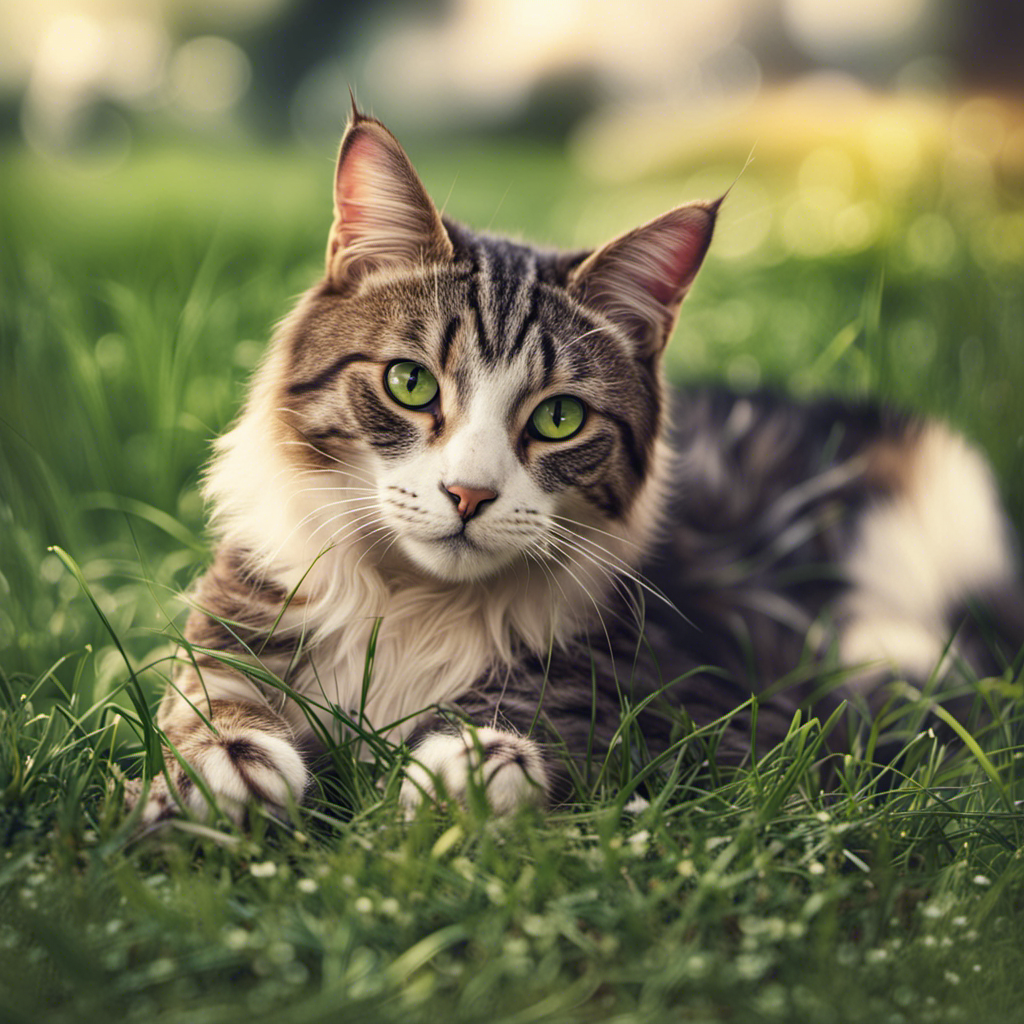

In [11]:
decode_and_show(output, image_name_1)

# <a id='toc3_'></a>[3: Delete the endpoint](#toc0_)

When you've finished working, you can delete the endpoint to release the EC2 instance(s) associated with it, and stop billing.

Get your list of Sagemaker endpoints using the AWS Sagemaker CLI like this:

In [12]:

# https://medium.com/@lily_su/accessing-s3-bucket-from-google-colab-16f7ee6c5b51

#!pip install awscli

#!aws sagemaker list-endpoints

# Delete an endpoint

In [13]:
# deployed_model.sagemaker_session.delete_endpoint(endpoint_name)
# # Rerun the aws cli command above to confirm that its gone.


#  Frank Morales created this cell on December 14, 2023; it fully allows automatically the deletion of endpoints, models, and endpoint configurations.
## TODO create a function for the loop

aws_region = 'us-east-1'
import boto3

sagemaker_client = boto3.client('sagemaker', region_name=aws_region)


print('')
print('Endpoints')
response=sagemaker_client.list_endpoints()
number_of_endpoints=len(response['Endpoints'])
for i in range(number_of_endpoints):
    print(response['Endpoints'][i]['EndpointName'])
    endpoint_name=response['Endpoints'][i]['EndpointName']
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)


print('')
print('Models')
response_models=sagemaker_client.list_models()
for i in range(len((response_models['Models']))):
    print(response_models['Models'][i]['ModelName'])
    sagemaker_client.delete_model(ModelName=response_models['Models'][i]['ModelName'])


print('')
print('EndpointConfigs')
response_configs=sagemaker_client.list_endpoint_configs()
for i in range(len((response_configs['EndpointConfigs']))):
    print(response_configs['EndpointConfigs'][i]['EndpointConfigName'])
    sagemaker_client.delete_endpoint_config(EndpointConfigName=response_configs['EndpointConfigs'][i]['EndpointConfigName'])


Endpoints
sdxl-1-0-intro-2023-12-15-07-19-29-244

Models
sdxl-v1-0-8cc703e-43ceeb816ad635d18270e-2023-12-15-07-20-22-648

EndpointConfigs
sdxl-1-0-intro-2023-12-15-07-19-29-244
